# Forager

An agent that has competing drives - hide in a safe area or traverse risky territory to visit food, which resets hunger. Hunger increases at each timestep that it isn't visiting food.

In [15]:
%pip install inferactively-pymdp

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


### Imports

In [16]:
import os
import sys
import pathlib
import numpy as np

from pymdp.agent import Agent
from pymdp import utils, maths

# Task
Develop and analyze an active inference agent for a camping and foraging task within a custom grid world environment. This involves:

1.  **Environment Setup**: Defining a `4x4` grid with 'food' at `(1,3)` and 'shelter' at `(3,0)`, a maximum hunger level of `9`, and a maximum risk level of `9`.
2.  **Generative Model Design**:
    *   **Hidden States**: `Location` (16 grid points), `Hunger Level` (0-9), and `Risk Level` (0-9).
    *   **Observations**: `Location Observation`, `Hunger Sensor`, `Square Type` ('Food', 'Shelter', 'Normal'), and `Risk Sensor`.
    *   **`A` Matrix**: An identity mapping for location, 'satiated' observation at the food square regardless of true hunger (otherwise perfect observation), accurate square type mapping, and 'safe' observation at the shelter regardless of true risk (otherwise perfect observation).
    *   **`B` Matrix**: Transitions for 5 actions (UP, DOWN, LEFT, RIGHT, STAY) for location, hunger increasing by 1 per timestep (capped at `max_hunger`), and risk increasing by 1 per timestep (capped at `max_risk`).
    *   **`C` Vector**: Identical preferences for low hunger and low risk, with negative preferences for high levels of either.
    *   **`D` Vector**: Initial belief of starting at `(0,0)` with hunger 0 and risk 0.
3.  **Generative Process (`GridWorldEnv`)**: Implementing a custom class that simulates true environment dynamics: hunger resets at food, risk resets at shelter, both increment otherwise (up to max).
4.  **Simulation & Analysis**: Running a simulation, tracking the agent's path, hunger, and risk, visualizing the results, and analyzing if the agent balances the competing drives to visit food and shelter.

## Define Environment Parameters

### Subtask:
Establish the grid dimensions, specific locations for 'food' and 'shelter' squares, a maximum hunger level, and how risk factors will be assigned to non-shelter squares. Also define the mapping of linear indices to (y,x) coordinates for the grid.


**Reasoning**:
The user provided specific instructions for defining the environment parameters, including grid dimensions, food/shelter locations, max hunger, and risk factors. I will generate the Python code to set up these parameters as specified.



In [17]:
# SCALED UP but still tractable
grid_dims = [4, 4]  # 4x4 grid (16 locations)
max_hunger = 5      # 0-5 (6 levels)
max_risk = 5        # 0-5 (6 levels)

# 3 steps apart - requires planning but journey < max level
food_location = (0, 3)    # Top-right corner
shelter_location = (0, 0) # Top-left corner (3 steps along top row)

num_grid_points = int(np.prod(grid_dims))  # 16 grid locations

# create a look-up table `loc_list` that maps linear indices to tuples of (y, x) coordinates
grid = np.arange(num_grid_points).reshape(grid_dims)
it = np.nditer(grid, flags=["multi_index"])

loc_list = []
while not it.finished:
    loc_list.append(it.multi_index)
    it.iternext()

distance = abs(food_location[0]-shelter_location[0]) + abs(food_location[1]-shelter_location[1])
total_states = num_grid_points * (max_hunger+1) * (max_risk+1)

print(f"Grid Dimensions: {grid_dims}")
print(f"Maximum Hunger/Risk Level: {max_hunger}")
print(f"Food Location: {food_location}")
print(f"Shelter Location: {shelter_location}")
print(f"Manhattan distance: {distance} steps")
print(f"Total unified states: {total_states}")
print(f"\n*** Journey ({distance} steps) < Max level ({max_hunger}) = Agent survives! ***")

Grid Dimensions: [4, 4]
Maximum Hunger/Risk Level: 5
Food Location: (0, 3)
Shelter Location: (0, 0)
Manhattan distance: 3 steps
Total unified states: 576

*** Journey (3 steps) < Max level (5) = Agent survives! ***


## Define Hidden State Factors

### Subtask:
Specify the agent's hidden state factors (`num_states`). You will need three factors: 1) Location (the agent's position in the grid), 2) Hunger Level (discrete levels from 0 to `max_hunger`), and 3) Risk Level (discrete levels from 0 to `max_risk`).

#### Instructions
1. Define `hunger_levels` as a NumPy array ranging from 0 to `max_hunger` (inclusive).2. Create a list called `num_states` where the first element is `num_grid_points` (representing the `Location` factor) and the second element is the length of `hunger_levels` (representing the `Hunger Level` factor).3. Print `hunger_levels` and `num_states` to verify their values.

**Reasoning**:
I will define the `hunger_levels` based on `max_hunger` and then combine it with `num_grid_points` to define `num_states` as a list, representing the dimensionalities of the hidden state factors as per the instructions.



In [18]:
hunger_levels = np.arange(max_hunger + 1) # 0 to max_hunger, inclusive
risk_levels = np.arange(max_risk + 1) # 0 to max_risk, inclusive

# Pre-compute indices for special locations
food_idx = loc_list.index(food_location)
shelter_idx = loc_list.index(shelter_location)

# UNIFIED STATE SPACE: Combine (Location × Hunger × Risk) into single factor
# This allows B matrix to encode location-dependent state resets
num_hunger = len(hunger_levels)
num_risk = len(risk_levels)
num_unified_states = num_grid_points * num_hunger * num_risk

print(f"Unified State Space: {num_grid_points} locations × {num_hunger} hunger × {num_risk} risk = {num_unified_states} states")
print(f"Food at index {food_idx}, Shelter at index {shelter_idx}")

# Mapping functions between unified index and (loc, hunger, risk) tuple
def unified_to_components(unified_idx):
    """Convert unified state index to (loc_idx, hunger, risk)"""
    risk = unified_idx % num_risk
    remainder = unified_idx // num_risk
    hunger = remainder % num_hunger
    loc_idx = remainder // num_hunger
    return loc_idx, hunger, risk

def components_to_unified(loc_idx, hunger, risk):
    """Convert (loc_idx, hunger, risk) to unified state index"""
    return loc_idx * num_hunger * num_risk + hunger * num_risk + risk

# Create lookup table for all unified states
unified_state_list = []
for u_idx in range(num_unified_states):
    loc_idx, hunger, risk = unified_to_components(u_idx)
    unified_state_list.append((loc_list[loc_idx], hunger, risk))

# Test mapping
test_idx = components_to_unified(food_idx, 5, 3)  # At food, hunger=5, risk=3
loc_i, h, r = unified_to_components(test_idx)
print(f"Test: food(idx={food_idx}), hunger=5, risk=3 -> unified={test_idx}")
print(f"Reverse: unified={test_idx} -> loc_idx={loc_i}, hunger={h}, risk={r}")

# Hidden states: single unified factor
num_states = [num_unified_states]

print(f"\nHidden State Dimensionalities: {num_states}")

Unified State Space: 16 locations × 6 hunger × 6 risk = 576 states
Food at index 3, Shelter at index 0
Test: food(idx=3), hunger=5, risk=3 -> unified=141
Reverse: unified=141 -> loc_idx=3, hunger=5, risk=3

Hidden State Dimensionalities: [576]


## Define Observation Modalities

### Subtask:
Specify the agent's observation modalities (`num_obs`). You will need four modalities: 1) Location Observation (the agent observes its position), 2) Hunger Sensor (the agent observes its internal hunger state), 3) Square Type (the agent observes if the current square is 'Food', 'Shelter', or 'Normal'), and 4) Risk Sensor (the agent observes its internal risk state).

**Reasoning**:
I will define the names for each observation modality and then create the `num_obs` list based on their dimensionalities, as specified in the instructions. This will complete the subtask of specifying the observation modalities.



In [19]:
location_obs_names = [f"({y},{x})" for y,x in loc_list] # For Location Observation
hunger_sensor_names = ['satiated'] + [f'hunger_{h}' for h in range(1, max_hunger + 1)] # 'satiated' is hunger_0
square_type_names = ['Food', 'Shelter', 'Normal']
risk_sensor_names = ['safe'] + [f'risk_{r}' for r in range(1, max_risk + 1)] # 'safe' is risk_0

# Observation modalities and their levels
num_obs = [
    num_grid_points, # Location Observation (number of grid points)
    len(hunger_sensor_names), # Hunger Sensor (satiated, hunger_1, ..., hunger_max_hunger)
    len(square_type_names), # Square Type (Food, Shelter, Normal)
    len(risk_sensor_names) # Risk Sensor (safe, risk_1, ..., risk_max_risk)
]

print(f"Observation Dimensionalities (Location, Hunger Sensor, Square Type, Risk Sensor): {num_obs}")
print(f"Hunger Sensor Names: {hunger_sensor_names}")
print(f"Square Type Names: {square_type_names}")
print(f"Risk Sensor Names: {risk_sensor_names}")

Observation Dimensionalities (Location, Hunger Sensor, Square Type, Risk Sensor): [16, 6, 3, 6]
Hunger Sensor Names: ['satiated', 'hunger_1', 'hunger_2', 'hunger_3', 'hunger_4', 'hunger_5']
Square Type Names: ['Food', 'Shelter', 'Normal']
Risk Sensor Names: ['safe', 'risk_1', 'risk_2', 'risk_3', 'risk_4', 'risk_5']


## Design Observation Model (A matrix)

### Subtask:
Construct the `A` matrix, paying close attention to dependencies for each observation modality.


**Reasoning**:
I will construct and fill out the A matrix (observation model) for all modalities as per the detailed instructions, ensuring correct dependencies and normalization, as a prerequisite for the generative model.



In [20]:
# A matrix shapes: [num_observations, num_unified_states] for each modality
A_m_shapes = [[o_dim, num_unified_states] for o_dim in num_obs]
A = utils.obj_array_zeros(A_m_shapes)

print(f"Building A matrices for unified state space ({num_unified_states} states)...")

# Fill A matrices by iterating over all unified states
for u_idx in range(num_unified_states):
    loc_idx, hunger, risk = unified_to_components(u_idx)
    
    # 1. A[0] - Location Observation - identity mapping for location component
    A[0][loc_idx, u_idx] = 1.0
    
    # 2. A[1] - Hunger Sensor
    # At food: always observe 'satiated'
    # Elsewhere: observe true hunger
    if loc_idx == food_idx:
        A[1][0, u_idx] = 1.0  # Always satiated at food
    else:
        A[1][hunger, u_idx] = 1.0  # True hunger elsewhere
    
    # 3. A[2] - Square Type - accurate mapping based on location
    if loc_idx == food_idx:
        A[2][square_type_names.index('Food'), u_idx] = 1.0
    elif loc_idx == shelter_idx:
        A[2][square_type_names.index('Shelter'), u_idx] = 1.0
    else:
        A[2][square_type_names.index('Normal'), u_idx] = 1.0
    
    # 4. A[3] - Risk Sensor
    # At shelter: always observe 'safe'
    # Elsewhere: observe true risk
    if loc_idx == shelter_idx:
        A[3][0, u_idx] = 1.0  # Always safe at shelter
    else:
        A[3][risk, u_idx] = 1.0  # True risk elsewhere

print("All A matrices filled.")
print("Food -> satiated observation, Shelter -> safe observation")

# Verification
all_normalized = True
for m in range(len(A)):
    sum_over_obs = A[m].sum(axis=0)
    is_norm_m = np.allclose(sum_over_obs, 1.0)
    if not is_norm_m:
        print(f"Warning: A[{m}] is NOT normalized. Sum range: {sum_over_obs.min():.2f} - {sum_over_obs.max():.2f}")
        all_normalized = False
print(f"All A sub-arrays are normalized: {all_normalized}")

Building A matrices for unified state space (576 states)...
All A matrices filled.
Food -> satiated observation, Shelter -> safe observation
All A sub-arrays are normalized: True


## Design Transition Model (B matrix)

### Subtask:
Construct the `B` matrix, paying close attention to the dynamics for each hidden state factor.

#### Instructions
1.  Define the `num_controls` list: This should specify the number of actions for each hidden state factor. For `Location`, there are 5 actions (UP, DOWN, LEFT, RIGHT, STAY). For `Hunger Level`, since it's an uncontrollable state, it should have 1 action.
2.  Initialize the `B` matrix as an object array of all-zero subarrays, using the `B_f_shapes` (calculated from `num_states` and `num_controls`) and the `utils.obj_array_zeros` function.


**Reasoning**:
The previous execution successfully addressed the A matrix construction. The next step is to define the `num_controls` and initialize the `B` matrix, as outlined in the subtask instructions.



In [21]:
# UNIFIED STATE: Single B matrix with 5 actions (UP, DOWN, LEFT, RIGHT, STAY)
num_controls = [5]  # Only one control factor now

# B matrix shape: [num_unified_states, num_unified_states, 5 actions]
B_f_shapes = [[num_unified_states, num_unified_states, 5]]
B = utils.obj_array_zeros(B_f_shapes)

print(f"B matrix initialized: shape {B[0].shape}")

B matrix initialized: shape (576, 576, 5)


#### Instructions
1. Fill out `B[0]` (Location transitions):
    * Iterate through each of the 5 possible actions (UP, DOWN, LEFT, RIGHT, STAY).
    * For each action, and for every `curr_state_idx` (representing a location), calculate the `next_state_idx` based on the action and grid boundaries (`grid_dims`).
    * Set the corresponding entry in `B[0][next_state_idx, curr_state_idx, action_id]` to 1.0, indicating a deterministic transition.

**Reasoning**:
I will now fill out the `B[0]` sub-array, which governs the transitions for the `Location` hidden state factor based on the 5 possible actions (UP, DOWN, LEFT, RIGHT, STAY).



In [22]:
actions = ["UP", "DOWN", "LEFT", "RIGHT", "STAY"]

print(f"Filling unified B matrix ({num_unified_states}x{num_unified_states}x5)...")
print("This encodes: location transitions + hunger/risk resets at food/shelter")

# Fill the unified B matrix
# For each (current unified state, action) -> next unified state
for action_id, action_label in enumerate(actions):
    for curr_u_idx in range(num_unified_states):
        # Decompose current unified state
        curr_loc_idx, curr_hunger, curr_risk = unified_to_components(curr_u_idx)
        curr_y, curr_x = loc_list[curr_loc_idx]
        
        # Compute next location based on action
        if action_label == "UP":
            next_y = curr_y - 1 if curr_y > 0 else curr_y
            next_x = curr_x
        elif action_label == "DOWN":
            next_y = curr_y + 1 if curr_y < (grid_dims[0]-1) else curr_y
            next_x = curr_x
        elif action_label == "LEFT":
            next_y = curr_y
            next_x = curr_x - 1 if curr_x > 0 else curr_x
        elif action_label == "RIGHT":
            next_y = curr_y
            next_x = curr_x + 1 if curr_x < (grid_dims[1]-1) else curr_x
        elif action_label == "STAY":
            next_y, next_x = curr_y, curr_x
        
        next_loc = (next_y, next_x)
        next_loc_idx = loc_list.index(next_loc)
        
        # Compute next hunger based on next location
        if next_loc == food_location:
            next_hunger = 0  # RESET at food!
        else:
            next_hunger = min(curr_hunger + 1, max_hunger)
        
        # Compute next risk based on next location
        if next_loc == shelter_location:
            next_risk = 0  # RESET at shelter!
        else:
            next_risk = min(curr_risk + 1, max_risk)
        
        # Compute next unified state
        next_u_idx = components_to_unified(next_loc_idx, next_hunger, next_risk)
        
        # Set transition probability
        B[0][next_u_idx, curr_u_idx, action_id] = 1.0

print("Unified B matrix filled!")
print("Key dynamics encoded:")
print(f"  - At food location ({food_location}): hunger resets to 0")
print(f"  - At shelter location ({shelter_location}): risk resets to 0")
print(f"  - Elsewhere: hunger and risk increase by 1 each timestep")

Filling unified B matrix (576x576x5)...
This encodes: location transitions + hunger/risk resets at food/shelter
Unified B matrix filled!
Key dynamics encoded:
  - At food location ((0, 3)): hunger resets to 0
  - At shelter location ((0, 0)): risk resets to 0
  - Elsewhere: hunger and risk increase by 1 each timestep


#### Instructions
1. Fill out `B[1]` (Hunger Level transitions):
    * Hunger increases by 1 each timestep, capped at `max_hunger`.
    * Set the corresponding entry in `B[1][next_hunger_state, current_hunger_state, 0]` to 1.0.
2. Fill out `B[2]` (Risk Level transitions):
    * Risk increases by 1 each timestep, capped at `max_risk`.
    * Set the corresponding entry in `B[2][next_risk_state, current_risk_state, 0]` to 1.0.

**Reasoning**:
I will now fill out the `B[1]` sub-array for the `Hunger Level` hidden state factor, implementing its transition dynamics as an increase of 1 per timestep, capped at `max_hunger`.



In [23]:
# With unified state space, hunger and risk transitions are now encoded directly
# in the single B[0] matrix above. No separate B[1] or B[2] needed!

# Verify B matrix is properly normalized (each column sums to 1)
for action_id in range(5):
    col_sums = B[0][:, :, action_id].sum(axis=0)
    if not np.allclose(col_sums, 1.0):
        print(f"Warning: B[0][:,:,{action_id}] columns don't sum to 1!")
    else:
        print(f"B[0][:,:,{action_id}] ({actions[action_id]}) is properly normalized")

print("\nB matrix verification complete.")

B[0][:,:,0] (UP) is properly normalized
B[0][:,:,1] (DOWN) is properly normalized
B[0][:,:,2] (LEFT) is properly normalized
B[0][:,:,3] (RIGHT) is properly normalized
B[0][:,:,4] (STAY) is properly normalized

B matrix verification complete.


## Prior Preferences (C vector)

### Subtask:
Define the agent's prior preferences (`C` vector). This involves setting high positive preferences for observations associated with well-being (e.g., low hunger, low risk) and high negative preferences for observations associated with undesirable states (e.g., high hunger, high risk).

#### Instructions
1. Initialize the `C` vector as an object array with all zeros, using `utils.obj_array_zeros` and `num_obs`.
2. Set preferences for the `Hunger Sensor` observation modality (`C[1]`):
    * Assign a high positive value to `'satiated'` (hunger 0).
    * Assign moderate positive values to low hunger levels.
    * Assign negative values to moderate hunger levels.
    * Assign a high negative value to `max_hunger`.
3. Set preferences for the `Risk Sensor` observation modality (`C[3]`):
    * Use the same preference distribution as hunger - positive for 'safe', increasingly negative for higher risk levels.

**Reasoning**:
I will now initialize the `C` vector and set the preferences for the `Hunger Sensor` and `Risk Feedback` observation modalities, as per the instructions in the previous markdown block.



In [24]:
C = utils.obj_array_zeros(num_obs)

# 6 levels (0-5): Journey is 3 steps, so levels 1-3 during transit, arrive at 3
# Need headroom to rest at destination before leaving again

# Hunger preferences
C[1][0] = 10.0    # satiated - good reward
C[1][1] = 0.0     # hunger_1 - fine (during journey)
C[1][2] = -1.0    # hunger_2 - slight discomfort (during journey)
C[1][3] = -3.0    # hunger_3 - uncomfortable (arrival level)
C[1][4] = -8.0    # hunger_4 - bad, should leave soon
C[1][5] = -50.0   # hunger_5 (max) - CATASTROPHIC!

# NO Square Type preferences
C[2][:] = 0.0

# Risk preferences - symmetric with hunger
C[3][0] = 10.0    # safe - good reward
C[3][1] = 0.0     # risk_1 - fine
C[3][2] = -1.0    # risk_2 - slight discomfort
C[3][3] = -3.0    # risk_3 - uncomfortable
C[3][4] = -8.0    # risk_4 - bad, should leave soon
C[3][5] = -50.0   # risk_5 (max) - CATASTROPHIC!

print("C (prior preferences) vector filled.")
print(f"Hunger preferences: {C[1]}")
print(f"Risk preferences: {C[3]}")
print("\nAgent can rest ~2 steps at destination before needing to leave")

C (prior preferences) vector filled.
Hunger preferences: [ 10.   0.  -1.  -3.  -8. -50.]
Risk preferences: [ 10.   0.  -1.  -3.  -8. -50.]

Agent can rest ~2 steps at destination before needing to leave


## Design Prior Over Initial States (D vector)

### Subtask:
Specify the agent's prior over initial hidden states, the `D` array.


#### Instructions
1. Initialize the `D` array as an object array with uniform priors, using `utils.obj_array_uniform` and `num_states`.
2. Set the agent's belief of starting at a specific location (e.g., `(0,0)`) by making the corresponding entry in `D[0]` a one-hot vector.
3. Set the agent's belief about its initial hunger level to 0 (satiated) by making the corresponding entry in `D[1]` a one-hot vector.
4. Set the agent's belief about its initial risk level to 0 (safe) by making the corresponding entry in `D[2]` a one-hot vector.

**Reasoning**:
I will now initialize the `D` vector as an object array with uniform priors, and then set specific one-hot beliefs for the initial location and hunger level, as instructed by the subtask.



In [25]:
# D vector for unified state space - single factor
D = utils.obj_array_uniform(num_states)  # num_states = [num_unified_states]

# Set agent's belief of starting at center (2,2) with hunger=0, risk=0
start_loc_idx = loc_list.index((2, 2))
start_hunger = 0
start_risk = 0
start_unified_idx = components_to_unified(start_loc_idx, start_hunger, start_risk)

D[0] = utils.onehot(start_unified_idx, num_unified_states)

print("D (prior over initial hidden states) vector filled.")
print(f"Starting beliefs: Location (2,2), Hunger {start_hunger}, Risk {start_risk}")
print(f"Unified state index: {start_unified_idx}")

D (prior over initial hidden states) vector filled.
Starting beliefs: Location (2,2), Hunger 0, Risk 0
Unified state index: 360


## Implement Generative Process (Environment)

### Subtask:
Create a custom `GridWorldEnv` class. This class will handle the true dynamics of the environment: tracking the agent's actual location, implementing hunger increment/reset rules, generating risk feedback based on randomly assigned risk factors for non-shelter squares, and returning the correct multi-modal observations to the agent based on its actions and the environment's state.

**Reasoning**:
I will define the `GridWorldEnv` class with `__init__`, `step`, and `reset` methods as specified in the instructions, implementing the environment's true dynamics for location, hunger, and observation generation.



In [26]:
class GridWorldEnv():

    def __init__(self, starting_loc, initial_hunger, initial_risk, food_location, shelter_location, 
                 grid_dims, max_hunger, max_risk, loc_list, hunger_levels, risk_levels,
                 hunger_sensor_names, square_type_names, risk_sensor_names):
        self.init_loc = starting_loc
        self.init_hunger = initial_hunger
        self.init_risk = initial_risk
        self.current_location = self.init_loc
        self.current_hunger = self.init_hunger
        self.current_risk = self.init_risk

        self.food_location = food_location
        self.shelter_location = shelter_location
        self.grid_dims = grid_dims
        self.max_hunger = max_hunger
        self.max_risk = max_risk
        self.loc_list = loc_list
        self.hunger_levels = hunger_levels
        self.risk_levels = risk_levels
        self.hunger_sensor_names = hunger_sensor_names
        self.square_type_names = square_type_names
        self.risk_sensor_names = risk_sensor_names

        print(f'Environment Initialized: Starting location is {self.init_loc}, Initial hunger is {self.init_hunger}, Initial risk is {self.init_risk}')

    def step(self, action_label):

        Y, X = self.current_location

        if action_label == "UP":
          Y_new = Y - 1 if Y > 0 else Y
          X_new = X
        elif action_label == "DOWN":
          Y_new = Y + 1 if Y < (self.grid_dims[0]-1) else Y
          X_new = X
        elif action_label == "LEFT":
          Y_new = Y
          X_new = X - 1 if X > 0 else X
        elif action_label == "RIGHT":
          Y_new = Y
          X_new = X + 1 if X < (self.grid_dims[1]-1) else X
        elif action_label == "STAY":
          Y_new, X_new = Y, X

        self.current_location = (Y_new, X_new) # store the new grid location

        # Update hunger - resets at food, otherwise increases
        if self.current_location == self.food_location:
            self.current_hunger = 0
        else:
            self.current_hunger = min(self.current_hunger + 1, self.max_hunger)

        # Update risk - resets at shelter, otherwise increases
        if self.current_location == self.shelter_location:
            self.current_risk = 0
        else:
            self.current_risk = min(self.current_risk + 1, self.max_risk)

        # Generate observations
        loc_obs = self.current_location

        hunger_obs = self.hunger_sensor_names[self.hunger_levels.tolist().index(self.current_hunger)]

        if self.current_location == self.food_location:
            square_type_obs = 'Food'
        elif self.current_location == self.shelter_location:
            square_type_obs = 'Shelter'
        else:
            square_type_obs = 'Normal'

        risk_obs = self.risk_sensor_names[self.risk_levels.tolist().index(self.current_risk)]

        return loc_obs, hunger_obs, square_type_obs, risk_obs

    def reset(self):
        self.current_location = self.init_loc
        self.current_hunger = self.init_hunger
        self.current_risk = self.init_risk
        print(f'Environment Reset: Location to {self.init_loc}, Hunger to {self.init_hunger}, Risk to {self.init_risk}')

        # Generate initial observations after reset
        loc_obs = self.current_location
        hunger_obs = self.hunger_sensor_names[self.hunger_levels.tolist().index(self.current_hunger)]

        if self.current_location == self.food_location:
            square_type_obs = 'Food'
        elif self.current_location == self.shelter_location:
            square_type_obs = 'Shelter'
        else:
            square_type_obs = 'Normal'

        risk_obs = self.risk_sensor_names[self.risk_levels.tolist().index(self.current_risk)]

        return loc_obs, hunger_obs, square_type_obs, risk_obs

## Run Active Inference Simulation

### Subtask:
Initialize the `Agent` with the designed A, B, C, D matrices and the `GridWorldEnv` instance. Run a simulation loop where the agent infers states, infers policies, selects an action, and the environment provides new observations, tracking the agent's path and hunger over time.

**Reasoning**:
I will now generate the Python code to run the active inference simulation loop, which includes initializing the `GridWorldEnv` and `Agent` with the previously defined components, and then iterating through the simulation steps, inferring states, policies, sampling actions, and recording the agent's history.



In [27]:
from pymdp.agent import Agent

# 1. Instantiate the GridWorldEnv class
# Start somewhere interesting - between food and shelter
starting_loc = (0, 1)  # Top row, one step from shelter
initial_hunger = 0
initial_risk = 0

my_env = GridWorldEnv(
    starting_loc=starting_loc,
    initial_hunger=initial_hunger,
    initial_risk=initial_risk,
    food_location=food_location,
    shelter_location=shelter_location,
    grid_dims=grid_dims,
    max_hunger=max_hunger,
    max_risk=max_risk,
    loc_list=loc_list,
    hunger_levels=hunger_levels,
    risk_levels=risk_levels,
    hunger_sensor_names=hunger_sensor_names,
    square_type_names=square_type_names,
    risk_sensor_names=risk_sensor_names
)

# 2. Call the reset() method on the environment instance
loc_obs, hunger_obs, square_type_obs, risk_obs = my_env.reset()

# 3. Convert initial observations from semantic names to numerical indices
obs = [
    loc_list.index(loc_obs),
    hunger_sensor_names.index(hunger_obs),
    square_type_names.index(square_type_obs),
    risk_sensor_names.index(risk_obs)
]

# 4. Update D to match starting state for unified state space
start_loc_idx = loc_list.index(starting_loc)
start_unified_idx = components_to_unified(start_loc_idx, initial_hunger, initial_risk)
D[0] = utils.onehot(start_unified_idx, num_unified_states)

# 5. Initialize the Agent class
# Policy length should cover the journey (3 steps) plus some buffer
policy_len = 4
my_agent = Agent(A=A, B=B, C=C, D=D, policy_len=policy_len)

# 6. Create empty lists to store the history
history_of_locs = [loc_obs]
history_of_hunger = [my_env.current_hunger]
history_of_risk = [my_env.current_risk]

# 7. Longer simulation to see multiple oscillations
T = 25

print(f"\n=== SCALED UP SIMULATION ===")
print(f"Total states: {num_unified_states} ({num_grid_points} locations × {num_hunger} hunger × {num_risk} risk)")
print(f"Starting at {starting_loc}, Hunger={initial_hunger}, Risk={initial_risk}")
print(f"Food at {food_location} (resets hunger), Shelter at {shelter_location} (resets risk)")
print(f"Policy length: {policy_len}")
print(f"Running {T} timesteps...")

# 8. Start a simulation loop
for t in range(T):
    print(f"\n--- Timestep {t+1}/{T} ---")
    qs = my_agent.infer_states(obs)
    my_agent.infer_policies()
    chosen_action_id = my_agent.sample_action()
    
    movement_id = int(chosen_action_id[0])
    choice_action = actions[movement_id]

    print(f'Chosen action: {choice_action}')

    loc_obs, hunger_obs, square_type_obs, risk_obs = my_env.step(choice_action)

    obs = [
        loc_list.index(loc_obs),
        hunger_sensor_names.index(hunger_obs),
        square_type_names.index(square_type_obs),
        risk_sensor_names.index(risk_obs)
    ]

    history_of_locs.append(loc_obs)
    history_of_hunger.append(my_env.current_hunger)
    history_of_risk.append(my_env.current_risk)

    print(f'Location: {loc_obs}, Hunger: {my_env.current_hunger}, Risk: {my_env.current_risk}')
    if loc_obs == food_location:
        print("  -> AT FOOD! (hunger reset)")
    if loc_obs == shelter_location:
        print("  -> AT SHELTER! (risk reset)")

print("\nSimulation finished.")

Environment Initialized: Starting location is (0, 1), Initial hunger is 0, Initial risk is 0
Environment Reset: Location to (0, 1), Hunger to 0, Risk to 0

=== SCALED UP SIMULATION ===
Total states: 576 (16 locations × 6 hunger × 6 risk)
Starting at (0, 1), Hunger=0, Risk=0
Food at (0, 3) (resets hunger), Shelter at (0, 0) (resets risk)
Policy length: 4
Running 25 timesteps...

--- Timestep 1/25 ---
Chosen action: LEFT
Location: (0, 0), Hunger: 1, Risk: 0
  -> AT SHELTER! (risk reset)

--- Timestep 2/25 ---
Chosen action: RIGHT
Location: (0, 1), Hunger: 2, Risk: 1

--- Timestep 3/25 ---
Chosen action: RIGHT
Location: (0, 2), Hunger: 3, Risk: 2

--- Timestep 4/25 ---
Chosen action: RIGHT
Location: (0, 3), Hunger: 0, Risk: 3
  -> AT FOOD! (hunger reset)

--- Timestep 5/25 ---
Chosen action: LEFT
Location: (0, 2), Hunger: 1, Risk: 4

--- Timestep 6/25 ---
Chosen action: LEFT
Location: (0, 1), Hunger: 2, Risk: 5

--- Timestep 7/25 ---
Chosen action: LEFT
Location: (0, 0), Hunger: 3, Risk: 

## Visualize Agent's Journey

Let's visualize the agent's path through the grid, showing the food and shelter locations, and the risk map.

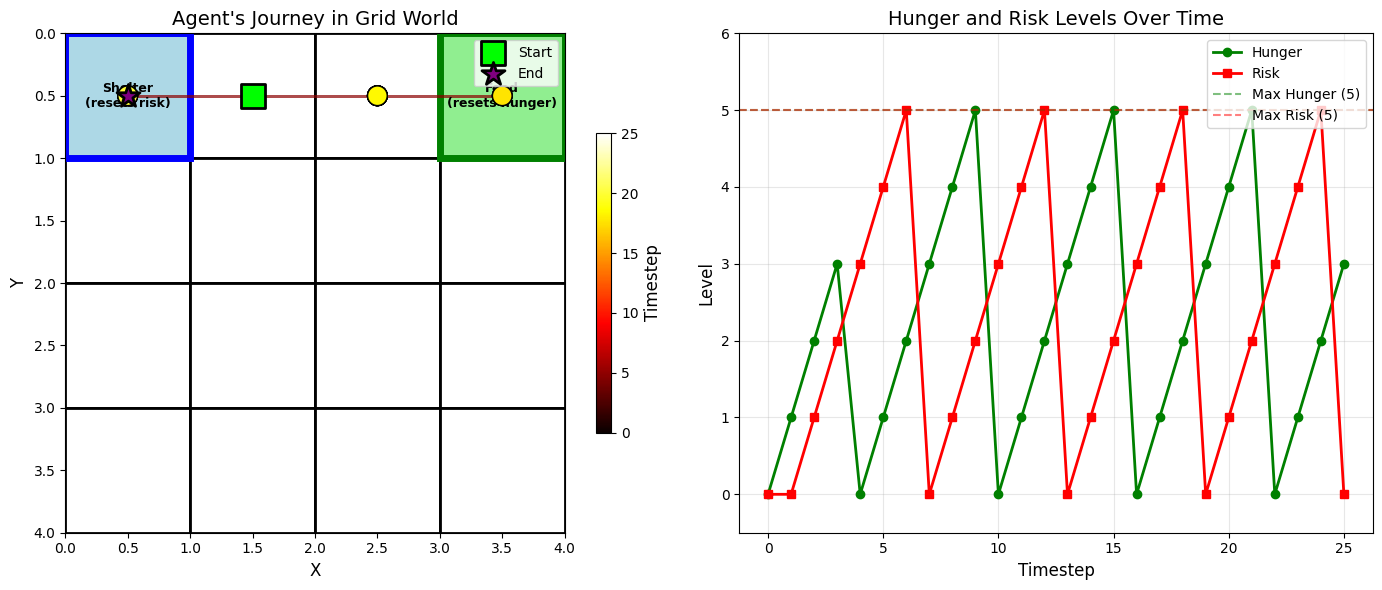


Journey Summary:
  Start: (0, 1), Hunger: 0, Risk: 0
  End: (0, 0), Hunger: 3, Risk: 0
  Total steps: 25
  Times at food: 4
  Times at shelter: 5


In [28]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import cm
import numpy as np

# Convert history of locations to numpy array
all_locations = np.vstack(history_of_locs).astype(float)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left plot: Grid with agent path
ax = axes[0]

# Create grid with pcolormesh for the background
X, Y = np.meshgrid(np.arange(grid_dims[1]+1), np.arange(grid_dims[0]+1))
ax.pcolormesh(X, Y, np.ones(grid_dims), edgecolors='k', linewidth=2, facecolor='white')

# Draw grid squares
for y in range(grid_dims[0]):
    for x in range(grid_dims[1]):
        rect = patches.Rectangle((x, y), 1.0, 1.0, linewidth=2, 
                                  edgecolor='k', facecolor='white')
        ax.add_patch(rect)

ax.invert_yaxis()

# Mark food location (green)
food_rect = patches.Rectangle((food_location[1], food_location[0]), 1.0, 1.0, 
                               linewidth=5, edgecolor='green', facecolor='lightgreen')
ax.add_patch(food_rect)
ax.text(food_location[1]+0.5, food_location[0]+0.5, 'Food\n(resets hunger)', fontsize=9, 
        ha='center', va='center', fontweight='bold')

# Mark shelter location (blue)  
shelter_rect = patches.Rectangle((shelter_location[1], shelter_location[0]), 1.0, 1.0,
                                  linewidth=5, edgecolor='blue', facecolor='lightblue')
ax.add_patch(shelter_rect)
ax.text(shelter_location[1]+0.5, shelter_location[0]+0.5, 'Shelter\n(resets risk)', fontsize=9,
        ha='center', va='center', fontweight='bold')

# Plot the agent's path
ax.plot(all_locations[:,1]+0.5, all_locations[:,0]+0.5, 'darkred', linewidth=2, zorder=2, alpha=0.7)

# Color the dots by time
temporal_colormap = cm.hot(np.linspace(0, 0.8, len(all_locations)))
dots = ax.scatter(all_locations[:,1]+0.5, all_locations[:,0]+0.5, 200, 
                  c=temporal_colormap, zorder=3, edgecolors='black', linewidth=1)

# Mark start and end positions
ax.scatter(all_locations[0,1]+0.5, all_locations[0,0]+0.5, 300, c='lime', 
           marker='s', zorder=4, edgecolors='black', linewidth=2, label='Start')
ax.scatter(all_locations[-1,1]+0.5, all_locations[-1,0]+0.5, 300, c='purple',
           marker='*', zorder=4, edgecolors='black', linewidth=2, label='End')

sm = plt.cm.ScalarMappable(cmap='hot', norm=plt.Normalize(vmin=0, vmax=T))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.6)
cbar.set_label('Timestep', fontsize=12)

ax.legend(loc='upper right', fontsize=10)
ax.set_xlim(0, grid_dims[1])
ax.set_ylim(grid_dims[0], 0)
ax.set_aspect('equal')
ax.set_xlabel('X', fontsize=12)
ax.set_ylabel('Y', fontsize=12)
ax.set_title(f"Agent's Journey in Grid World", fontsize=14)

# Right plot: Hunger and Risk over time
ax2 = axes[1]
timesteps = np.arange(len(history_of_hunger))
ax2.plot(timesteps, history_of_hunger, 'g-o', label='Hunger', linewidth=2, markersize=6)
ax2.plot(timesteps, history_of_risk, 'r-s', label='Risk', linewidth=2, markersize=6)
ax2.axhline(y=max_hunger, color='g', linestyle='--', alpha=0.5, label=f'Max Hunger ({max_hunger})')
ax2.axhline(y=max_risk, color='r', linestyle='--', alpha=0.5, label=f'Max Risk ({max_risk})')
ax2.set_xlabel('Timestep', fontsize=12)
ax2.set_ylabel('Level', fontsize=12)
ax2.set_title('Hunger and Risk Levels Over Time', fontsize=14)
ax2.legend(loc='upper right')
ax2.set_ylim(-0.5, max(max_hunger, max_risk) + 1)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary
print(f"\nJourney Summary:")
print(f"  Start: {history_of_locs[0]}, Hunger: {history_of_hunger[0]}, Risk: {history_of_risk[0]}")
print(f"  End: {history_of_locs[-1]}, Hunger: {history_of_hunger[-1]}, Risk: {history_of_risk[-1]}")
print(f"  Total steps: {len(history_of_locs)-1}")
print(f"  Times at food: {sum(1 for loc in history_of_locs if loc == food_location)}")
print(f"  Times at shelter: {sum(1 for loc in history_of_locs if loc == shelter_location)}")